In [1]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LambdaCallback, EarlyStopping, ReduceLROnPlateau
import pickle 

In [2]:
# Bước 1: Chuẩn bị dữ liệu
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        if not os.path.isdir(label_folder):
            continue
        for filename in os.listdir(label_folder):
            img_path = os.path.join(label_folder, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))  # Thay đổi kích thước hình ảnh nếu cần
                images.append(img)
                labels.append(label)
            else:
                print(f"Error loading image {img_path}")
    return np.array(images), np.array(labels)

folder_path = 'Database'
images, labels = load_images_from_folder(folder_path)

# Chuyển đổi nhãn thành số
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

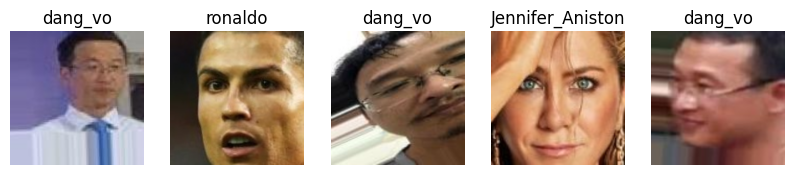

In [3]:
# Hiển thị một số mẫu hình ảnh và nhãn
def show_sample_images(images, labels, label_encoder, num_samples=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        idx = np.random.randint(0, len(images))
        img = images[idx]
        label = labels[idx]
        plt.subplot(1, num_samples, i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(label_encoder.inverse_transform([label])[0])
        plt.axis('off')
    plt.show()

show_sample_images(images, encoded_labels, label_encoder)


In [4]:
# Kiểm tra và xử lý dữ liệu bị thiếu hoặc không hợp lệ
valid_indices = [i for i, img in enumerate(images) if img is not None]
images = images[valid_indices]
encoded_labels = encoded_labels[valid_indices]

# Cân bằng dữ liệu (nếu cần)
unique, counts = np.unique(encoded_labels, return_counts=True)
max_count = np.max(counts)

balanced_images = []
balanced_labels = []

for label in unique:
    label_indices = np.where(encoded_labels == label)[0]
    label_images = images[label_indices]
    if len(label_images) < max_count:
        label_images = resample(label_images, replace=True, n_samples=max_count, random_state=42)
    balanced_images.extend(label_images)
    balanced_labels.extend([label] * max_count)

balanced_images = np.array(balanced_images)
balanced_labels = np.array(balanced_labels)

In [5]:
# Chuẩn hóa dữ liệu
balanced_images = balanced_images.astype('float32') 
#balanced_images = preprocess_input_resnet50(balanced_images)
balanced_images = balanced_images.astype('float32') / 255.0

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(balanced_images, balanced_labels, test_size=0.2, random_state=42)
 

# Sử dụng ImageDataGenerator để tăng cường dữ liệu
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

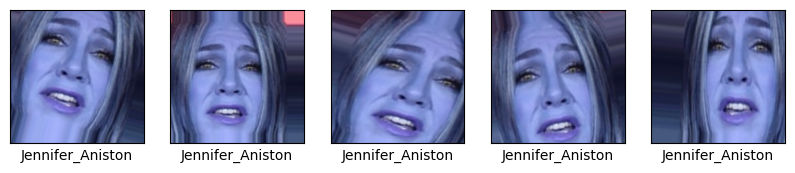

In [6]:
# Tạo ra một số mẫu ảnh sau khi tăng cường dữ liệu và hiển thị chúng
sample_image = X_train[0]  # Lấy một ảnh mẫu từ tập huấn luyện
sample_label = y_train[0]

# Chuyển đổi ảnh mẫu thành định dạng phù hợp với ImageDataGenerator
sample_image = np.expand_dims(sample_image, axis=0) 
# Tạo các ảnh tăng cường
augmented_images = datagen.flow(sample_image, batch_size=1)
  
  
# Hiển thị các ảnh tăng cường
plt.figure(figsize=(10, 10)) 
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    augmented_image = next(augmented_images)[0]
    augmented_image = np.clip(augmented_image, 0, 1) 
    plt.imshow(augmented_image)
    plt.xlabel(label_encoder.inverse_transform([sample_label])[0])
plt.show() 

In [7]:
# Step 2: Built CNN
model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

In [8]:

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,605 (42.61 MB)

 Trainable params: 11,169,605 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Tạo callback để hiển thị độ chính xác và hàm mất mát sau mỗi 10 epochs
def on_epoch_end(epoch, logs):
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}:")
        print(f" - loss: {logs['loss']:.4f} - accuracy: {logs['accuracy']:.4f}")
        print(f" - val_loss: {logs['val_loss']:.4f} - val_accuracy: {logs['val_accuracy']:.4f}")

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [10]:
# B3: Huấn luyện mô hình với 20 epochs và callback
epochs_number = 20

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32), 
    epochs=epochs_number, 
    validation_data=(X_test, y_test), 
    callbacks=[print_callback, early_stopping,reduce_lr],
    workers=4,  # Number of worker threads
    use_multiprocessing=True,  # Use multiprocessing
    max_queue_size=10  # Size of the generator queue
    )

Epoch 1/20


d:\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


265/265 ━━━━━━━━━━━━━━━━━━━━ 283s 1s/step - accuracy: 0.4165 - loss: 1.4610 - val_accuracy: 0.8241 - val_loss: 0.5790 - learning_rate: 0.0010
Epoch 2/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 237s 886ms/step - accuracy: 0.6842 - loss: 0.8135 - val_accuracy: 0.8519 - val_loss: 0.4369 - learning_rate: 0.0010
Epoch 3/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 237s 884ms/step - accuracy: 0.7498 - loss: 0.6791 - val_accuracy: 0.8575 - val_loss: 0.3664 - learning_rate: 0.0010
Epoch 4/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 240s 894ms/step - accuracy: 0.7847 - loss: 0.5866 - val_accuracy: 0.8986 - val_loss: 0.2778 - learning_rate: 0.0010
Epoch 5/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 242s 904ms/step - accuracy: 0.8130 - loss: 0.5189 - val_accuracy: 0.9024 - val_loss: 0.2738 - learning_rate: 0.0010
Epoch 6/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 232s 865ms/step - accuracy: 0.8205 - loss: 0.4861 - val_accuracy: 0.9222 - val_loss: 0.2254 - learning_rate: 0.0010
Epoch 7/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 236s 880ms/step - accuracy: 0.8317 - l

In [11]:
# Bước 4: Đánh giá mô hình
loss, accuracy = model.evaluate(X_test, y_test)
#print(f'Test accuracy of the model is -: {accuracy}')
print("Accuracy of the model is - " , accuracy*100 , "%")

67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - accuracy: 0.9733 - loss: 0.0691
Accuracy of the model is -  97.2169816493988 %


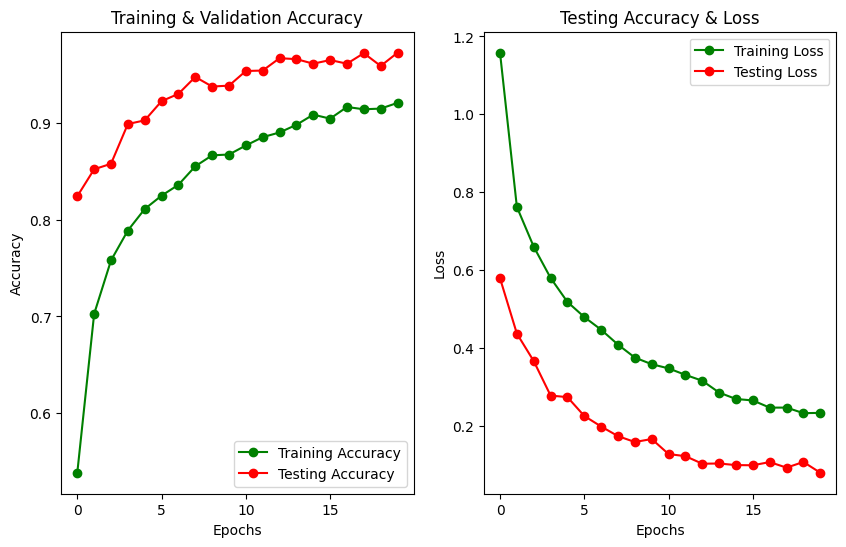

In [12]:
epochs = [i for i in range(epochs_number)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(10,6)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
#ax[0].yticks(np.arange(0, 1.1, 0.1))  # Chia mốc y-axis theo bước 0.1
#ax[0].xticks(np.arange(0, epochs_number, 10))    # Chia mốc x-axis theo bước 10

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
#ax[1].xticks(np.arange(0, epochs_number, 10))    # Chia mốc x-axis theo bước 10
plt.show()

67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step


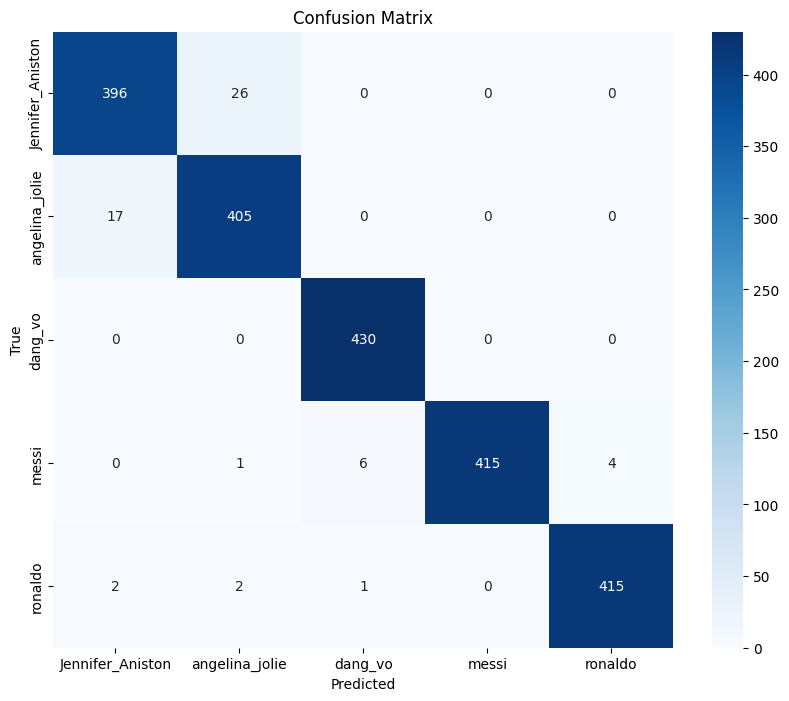

In [13]:
# Hiển thị confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [14]:
# Hiển thị báo cáo phân loại
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))


                  precision    recall  f1-score   support

Jennifer_Aniston       0.95      0.94      0.95       422
  angelina_jolie       0.93      0.96      0.95       422
         dang_vo       0.98      1.00      0.99       430
           messi       1.00      0.97      0.99       426
         ronaldo       0.99      0.99      0.99       420

        accuracy                           0.97      2120
       macro avg       0.97      0.97      0.97      2120
    weighted avg       0.97      0.97      0.97      2120



In [16]:
# Lưu mô hình và LabelEncoder
model.save('face_recognition_cnn_model.keras')
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

<!-- # Bước 5: Sử dụng mô hình để nhận diện khuôn mặt real-time
import time

# Load mô hình và label encoder
model = tf.keras.models.load_model('face_recognition_resnet50_model.keras')
with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# Hàm nhận diện khuôn mặt real-time
def recognize_faces_in_frame(frame, model, label_encoder):
    faces = []
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    detected_faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in detected_faces:
        face = frame[y:y+h, x:x+w]
        face = cv2.resize(face, (128, 128))
        face = face.astype('float32') / 255.0
        face = np.expand_dims(face, axis=0)
        predictions = model.predict(face)
        predicted_label = np.argmax(predictions)
        predicted_name = label_encoder.inverse_transform([predicted_label])[0]
        faces.append((x, y, w, h, predicted_name))
    return faces

# Mở camera và nhận diện khuôn mặt
cap = cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()
    if not ret:
        break
    faces = recognize_faces_in_frame(frame, model, label_encoder)
    for (x, y, w, h, name) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, name, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
    cv2.imshow('Face Recognition', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows() -->